In [1]:
%matplotlib inline

In [2]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import patsy as pat
import seaborn as sbn
import nibabel as nib
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pathlib as pal
from scipy import stats
from scipy import io as sio
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import metrics as skm
from sklearn import linear_model as sln
from sklearn import preprocessing as skp
from statsmodels.sandbox.stats.multicomp import multipletests as stm

In [3]:
# Paths
root_p = pal.Path('/home/surchs/data/')
data_abide_p = root_p / 'paper_16p22q/glm/abide/cambridge64/individual/'
pheno_abide_p = root_p / 'paper_16p22q/pheno/abide_men.csv'
temp = 'connectome_s{}_cambridge64.mat'
figure_p = root_p / 'paper_16p22q/figures/unclear/'

labels_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
hier_p = root_p / 'ATLAS/MIST/Hierarchy/MIST_PARCEL_ORDER.csv'
temp_p = root_p / 'ATLAS/MIST/Parcellations/MIST_64.nii.gz'

dc16_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
dp16_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/dup_minus_con/glm_dup_minus_con_cambridge64.mat'
dc22_p = root_p / 'paper_16p22q/glm/22q/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
dp22_p = root_p / 'paper_16p22q/glm/22q/cambridge64/dup_minus_con/glm_dup_minus_con_cambridge64.mat'

In [4]:
# Load the MIST64 template
temp_i = nib.load(str(temp_p))
mist64 = temp_i.get_data()
# Get the parcel info
label = pd.read_csv(labels_p, delimiter=';')
hier = pd.read_csv(hier_p)

In [5]:
# Get the scale 64 hierarchy
_, idx = np.unique(hier.s64.values, return_index=True)
hier64 = hier.s64.values[np.sort(idx)]
part64 = hier.s7.values[np.sort(idx)]
transitions64 = [(i, idx+1) for idx, i in enumerate(part64[1:]) if part64[idx]!=part64[idx+1]]

In [6]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

In [7]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [8]:
def vec2mat(vec, mask):
    tmp_mat = octvec2mat(vec, mask)
    tmp_mat += tmp_mat.T
    tmp_mat[np.eye(mask.shape[0]).astype(bool)] = tmp_mat[np.eye(mask.shape[0]).astype(bool)]/2
    return tmp_mat

In [9]:
# Get the 22q
dc22_pattern = np.array(sio.loadmat(dc22_p)['eff']).squeeze()
# Map back to matrix
dc22_mat = octvec2mat(dc22_pattern, np.tril(np.ones((64,64))).astype(bool))
dc22_mat += dc22_mat.T
dref = dc22_mat[np.identity(64, dtype=bool)]
dc22_mat[np.identity(64, dtype=bool)] = dref/2

In [10]:
# Get the 16p
dc16_pattern = np.array(sio.loadmat(dc16_p)['eff']).squeeze()
# Map back to matrix
dc16_mat = octvec2mat(dc16_pattern, np.tril(np.ones((64,64))).astype(bool))
dc16_mat += dc16_mat.T
dref = dc16_mat[np.identity(64, dtype=bool)]
dc16_mat[np.identity(64, dtype=bool)] = dref/2

## Compare the two patterns

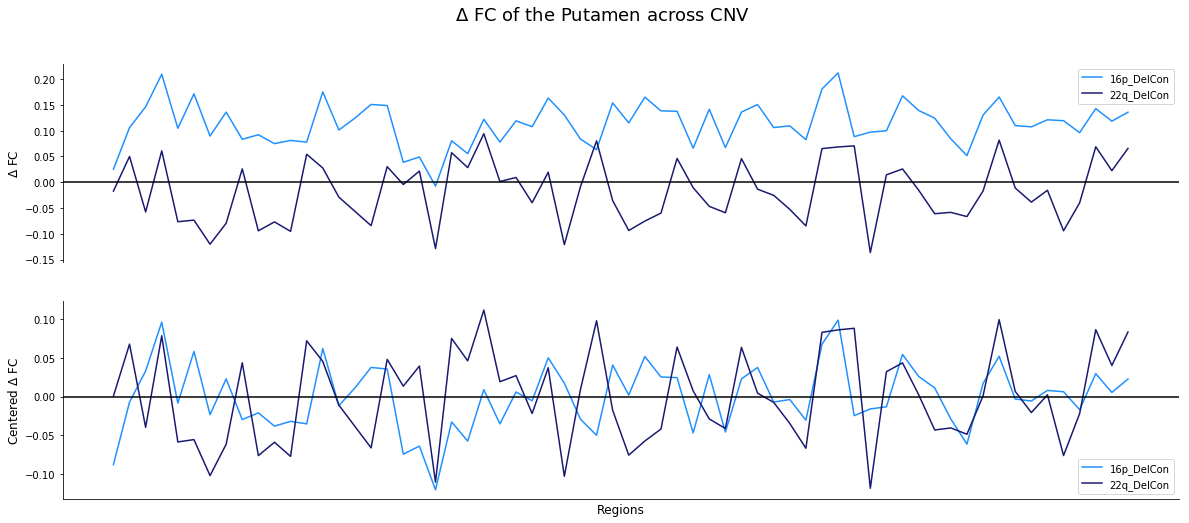

In [11]:
# Show me the 22q del signature of the putamen
nid = 0
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(211)
ax1.plot(dc16_mat[nid, :], label='16p_DelCon', color='dodgerblue')
ax1.plot(dc22_mat[nid, :], label='22q_DelCon', color='midnightblue')
ax1.axhline(0, color='k')
ax1.set_xticks([])
#ax1.set_xlabel('Regions', fontsize=12)
ax1.set_ylabel('$\Delta$ FC', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.legend()

ax2 = f.add_subplot(212)
ax2.plot(dc16_mat[nid, :] - np.mean(dc16_mat[nid, :]), label='16p_DelCon', color='dodgerblue')
ax2.plot(dc22_mat[nid, :] - np.mean(dc22_mat[nid, :]), label='22q_DelCon', color='midnightblue')
ax2.axhline(0, color='k')
ax2.set_xticks([])
ax2.set_xlabel('Regions', fontsize=12)
ax2.set_ylabel('Centered $\Delta$ FC', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.legend()

f.suptitle('$\Delta$ FC of the Putamen across CNV', fontsize=18);
f.savefig(os.path.join(figure_p, 'deltaFC_acrossCNV_putamen.pdf'), dpi=300, transparent=True)

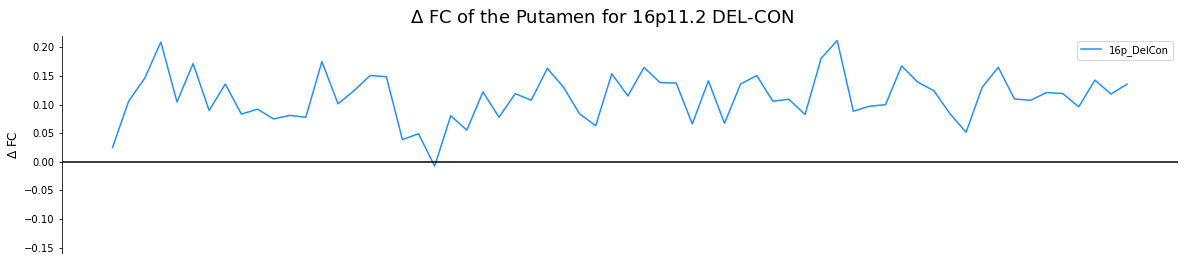

In [12]:
# Show the two patterns individually
nid = 0
f = plt.figure(figsize=(20,4))
ax1 = f.add_subplot(111)
ax1.plot(dc16_mat[nid, :], label='16p_DelCon', color='dodgerblue')
ax1.axhline(0, color='k')
ax1.set_xticks([])
#ax1.set_xlabel('Regions', fontsize=12)
ax1.set_ylabel('$\Delta$ FC', fontsize=12)
ax1.set_ylim([-0.16, 0.22])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.legend()

f.suptitle('$\Delta$ FC of the Putamen for 16p11.2 DEL-CON', fontsize=18);
f.savefig(os.path.join(figure_p, 'deltaFC_16p_delcon_putamen.pdf'), dpi=300, transparent=True)

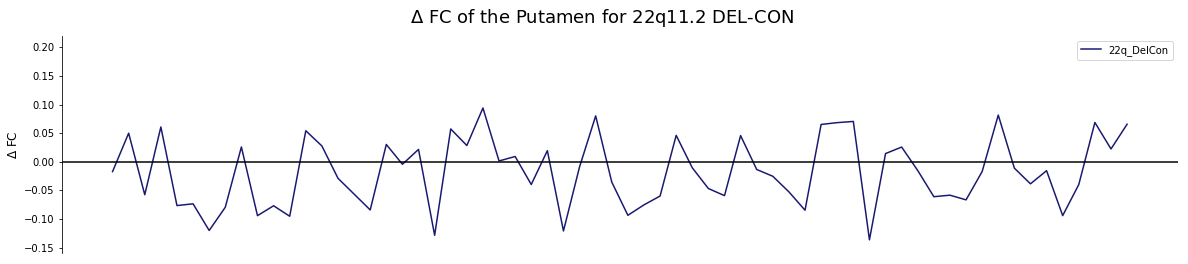

In [13]:
# Show the two patterns individually
nid = 0
f = plt.figure(figsize=(20,4))
ax1 = f.add_subplot(111)
ax1.plot(dc22_mat[nid, :], label='22q_DelCon', color='midnightblue')
ax1.axhline(0, color='k')
ax1.set_xticks([])
#ax1.set_xlabel('Regions', fontsize=12)
ax1.set_ylabel('$\Delta$ FC', fontsize=12)
ax1.set_ylim([-0.16, 0.22])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.legend()

f.suptitle('$\Delta$ FC of the Putamen for 22q11.2 DEL-CON', fontsize=18);
f.savefig(os.path.join(figure_p, 'deltaFC_22q_delcon_putamen.pdf'), dpi=300, transparent=True)

## Get some ABIDE subjects and show their vector profile

In [14]:
pheno_abide = pd.read_csv(pheno_abide_p)

In [15]:
example_abide_control_subject = pheno_abide[pheno_abide.DX_GROUP=='Control'].SUB_ID.values[-1]
example_abide_autism_subject = pheno_abide[pheno_abide.DX_GROUP=='Autism'].SUB_ID.values[-1]

In [16]:
conn_abide_con = sio.loadmat(str(data_abide_p / temp.format(example_abide_control_subject)))['asd_con'][0][0][0].squeeze()
mat_abide_con = vec2mat(conn_abide_con, np.tril(np.ones((64, 64)).astype(bool)))
conn_abide_asd = sio.loadmat(str(data_abide_p / temp.format(example_abide_autism_subject)))['asd_con'][0][0][0].squeeze()
mat_abide_asd = vec2mat(conn_abide_asd, np.tril(np.ones((64, 64)).astype(bool)))

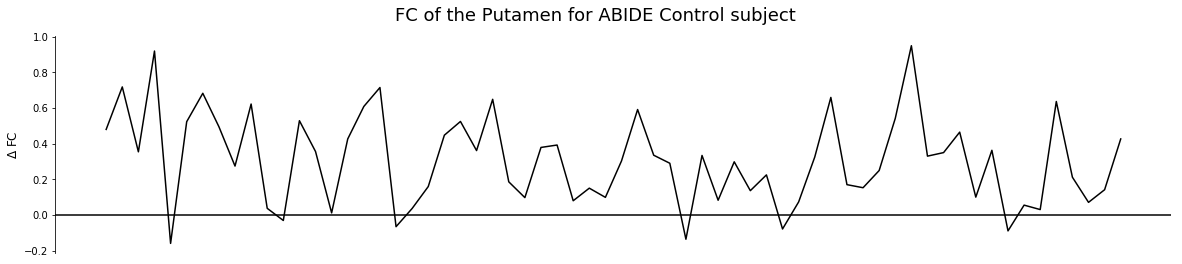

In [17]:
# Show the two patterns individually
nid = 0
f = plt.figure(figsize=(20,4))
ax1 = f.add_subplot(111)
ax1.plot(mat_abide_con[nid, :], color='black')
ax1.axhline(0, color='k')
ax1.set_xticks([])
#ax1.set_xlabel('Regions', fontsize=12)
ax1.set_ylabel('$\Delta$ FC', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

f.suptitle('FC of the Putamen for ABIDE Control subject', fontsize=18);
f.savefig(os.path.join(figure_p, 'ABIDE_con_example_putamen_vector.pdf'), dpi=300, transparent=True)

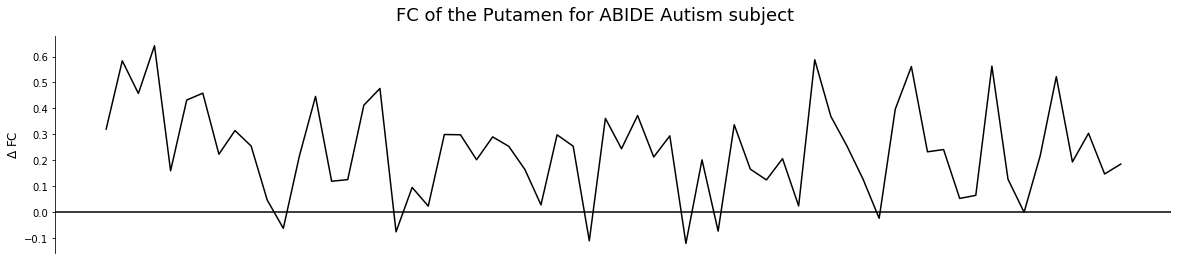

In [18]:
# Show the two patterns individually
nid = 0
f = plt.figure(figsize=(20,4))
ax1 = f.add_subplot(111)
ax1.plot(mat_abide_asd[nid, :], color='black')
ax1.axhline(0, color='k')
ax1.set_xticks([])
#ax1.set_xlabel('Regions', fontsize=12)
ax1.set_ylabel('$\Delta$ FC', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

f.suptitle('FC of the Putamen for ABIDE Autism subject', fontsize=18);
f.savefig(os.path.join(figure_p, 'ABIDE_asd_example_putamen_vector.pdf'), dpi=300, transparent=True)